In [6]:
def plot_variables(file,time): # Plotting the dataset.

    import xarray as xr
    import matplotlib.pyplot as plt
    import os

    ds = xr.open_dataset(file)

    fig, ax = plt.subplots(2, 2, figsize=(10, 5))

    ds.isel(time=time).wind_speed.plot(ax=ax[0, 0])
    ax[0, 0].set_title('Wind Speed')

    ds.isel(time=time).wind_divergence.plot(ax=ax[0, 1])
    ax[0, 1].set_title('Wind Divergence')

    ds.isel(time=time).eastward_wind.plot(ax=ax[1, 0])
    ax[1, 0].set_title('Eastward Wind')

    ds.isel(time=time).northward_wind.plot(ax=ax[1, 1])
    ax[1, 1].set_title('Northward Wind')

    plt.tight_layout()

    filename = os.path.basename(file)

    filename_without_ext = os.path.splitext(filename)[0]

    fig.savefig(f'../Plots/{filename_without_ext}_parameters_plot.png')



In [33]:
import numpy as np
import matplotlib.pyplot as plt

spliced_filter_asc = '../Output/Full_dataset_spliced_filtered_asc.npy'
spliced_filter_des = '../Output/Full_dataset_spliced_filtered_des.npy'

spliced_filter_asc = np.load(spliced_filter_asc)
spliced_filter_des = np.load(spliced_filter_des)

print(spliced_filter_asc.shape)
print(spliced_filter_des.shape)


(816, 41, 41)
(816, 41, 41)


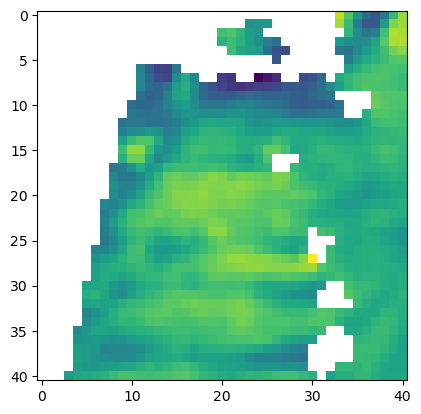

In [57]:
# Okay we actually don't want to do this at this step. We want to do it at the very beginning. We are not looking at 
i = np.random.randint(0,spliced_filter_des.shape[0])
plt.imshow(spliced_filter_des[i])


(664, 41, 41) normal = 816
run done


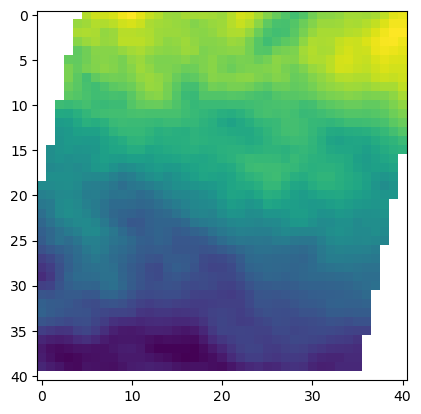

In [8]:
def hash_array(array):
    import hashlib
    # Convert the array to a byte representation
    array_bytes = array.tobytes()
    # Use a hash function like SHA-256
    return hashlib.md5(array_bytes).hexdigest()

def count_nan_clusters(array):
    import numpy as np
    from scipy.ndimage import label

    # Create a boolean array: True where the original array is NaN
    nan_mask = np.isnan(array)
    
    # Label connected components of NaNs
    labeled_array, num_features = label(nan_mask)
    
    # num_features is the number of connected NaN clusters
    return num_features

def splice_filter_pad_asc(file,angle,cutoff_percentage):

    import numpy as np
    import xarray as xr
    import os
    import matplotlib.pyplot as plt

    
    ds = xr.open_dataset(file)

    # Isolating the array of longitude
    longitude = ds.longitude
    latitude = ds.latitude

    range_angle = angle # in degrees

    # Creating a function that takes every 5 degrees of longitude
    min_longtitude = np.min(longitude)
    max_longtitude = np.max(longitude)
    range_longitude = np.arange(min_longtitude,max_longtitude,range_angle)

    min_latitude = np.min(latitude)
    max_latitude = np.max(latitude)
    range_latitude = np.arange(min_latitude,max_latitude,range_angle)

    time_max = np.max(np.shape(ds.time))
    range_time = np.arange(0,time_max,1)

    time = np.arange(0,time_max,1)
    latitude_range = np.arange(min_latitude,max_latitude,range_angle)
    longitude_range = np.arange(min_longtitude,max_longtitude,range_angle)

    dataset_separated = []
    metadata_entries = []    

    max_rows = 0
    max_cols = 0

    for lat in latitude_range:
        for lon in longitude_range:
            all_windspeed_selection = np.array(ds.isel(time=time).wind_speed.sel(latitude=slice(lat, lat+range_angle), longitude=slice(lon, lon+range_angle)))
            for k in range(len(all_windspeed_selection)):
                missing_values = np.isnan(all_windspeed_selection[k])
                percentage_missing = np.mean(missing_values) * 100
                if percentage_missing < cutoff_percentage & count_nan_clusters(spliced_filter_des[i])<3:
                    dataset_separated.append(all_windspeed_selection[k])
                    rows, cols = all_windspeed_selection[k].shape
                    max_rows = max(max_rows, rows)
                    max_cols = max(max_cols, cols)
                    # Collect metadata entries
                    metadata_entries.append({
                        'latitude start': lat,
                        'latitude end': lat + range_angle,
                        'longitude start': lon,
                        'longitude end': lon + range_angle,
                        'time': k,
                        'source': 'asc'  # Adjust 'SomeSource' as needed
                    })

    # Pad arrays with np.nan to make them all the same size
    dataset_separated = [np.pad(arr, ((0, max_rows - arr.shape[0]), (0, max_cols - arr.shape[1])), 'constant', constant_values=np.nan) for arr in dataset_separated]

    #Convert metadata list to dataframe for export
    metadata = pd.DataFrame(metadata_entries)
    metadata.to_csv('../Output/Metadata/metadata_asc.csv', index=False)

    np.save('../Output/Full_dataset_spliced_filtered_asc.npy', dataset_separated)

    print('run done')

def splice_filter_pad_des(file,angle,cutoff_percentage):

    import numpy as np
    import xarray as xr
    import os
    import matplotlib.pyplot as plt
    import pandas as pd

    ds = xr.open_dataset(file)

    # Isolating the array of longitude
    longitude = ds.longitude
    latitude = ds.latitude

    range_angle = angle # in degrees

    # Creating a function that takes every 5 degrees of longitude
    min_longtitude = np.min(longitude)
    max_longtitude = np.max(longitude)
    range_longitude = np.arange(min_longtitude,max_longtitude,range_angle)

    min_latitude = np.min(latitude)
    max_latitude = np.max(latitude)
    range_latitude = np.arange(min_latitude,max_latitude,range_angle)

    time_max = np.max(np.shape(ds.time))
    range_time = np.arange(0,time_max,1)

    time = np.arange(0,time_max,1)
    latitude_range = np.arange(min_latitude,max_latitude,range_angle)
    longitude_range = np.arange(min_longtitude,max_longtitude,range_angle)

    dataset_separated = []
    metadata_entries = []    
    max_rows = 0
    max_cols = 0

    for lat in latitude_range:
        for lon in longitude_range:
            all_windspeed_selection = np.array(ds.isel(time=time).wind_speed.sel(latitude=slice(lat, lat+range_angle), longitude=slice(lon, lon+range_angle)))
            for k in range(len(all_windspeed_selection)):
                missing_values = np.isnan(all_windspeed_selection[k])
                percentage_missing = np.mean(missing_values) * 100
                if percentage_missing < cutoff_percentage and count_nan_clusters(all_windspeed_selection[k])<3:
                    dataset_separated.append(all_windspeed_selection[k])
                    rows, cols = all_windspeed_selection[k].shape
                    max_rows = max(max_rows, rows)
                    max_cols = max(max_cols, cols)
                    hash = hash_array(all_windspeed_selection[k])
                    # Collect metadata entries
                    metadata_entries.append({
                        'latitude start': lat,
                        'latitude end': lat + range_angle,
                        'longitude start': lon,
                        'longitude end': lon + range_angle,
                        'time': k,
                        'source': 'des',  # Adjust 'SomeSource' as needed
                        'hash': hash
                    })
    # Pad arrays with np.nan to make them all the same size
    dataset_separated = [np.pad(arr, ((0, max_rows - arr.shape[0]), (0, max_cols - arr.shape[1])), 'constant', constant_values=np.nan) for arr in dataset_separated]

    #Convert metadata list to dataframe for export
    metadata = pd.DataFrame(metadata_entries)
    metadata.to_csv('../Output/Metadata/metadata_des.csv', index=False)

    np.save('../Output/Full_dataset_spliced_filtered_des.npy', dataset_separated)
    
    #Remove after debugging
    plt.imshow(dataset_separated[400])
    print(np.shape(dataset_separated),'normal = 816')
    print('run done')

splice_filter_pad_des('D:\METOP-A ML\TO CLUSTER\Data\cmems_obs-wind_glo_phy_my_l3-metopa-ascat-asc-0.125deg_P1D-i-2007_2021.nc',5,30)

In [10]:
# Verifying metadata match


import xarray as xr
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

ds = xr.open_dataset('D:\METOP-A ML\TO CLUSTER\Data\cmems_obs-wind_glo_phy_my_l3-metopa-ascat-asc-0.125deg_P1D-i-2007_2021.nc')


metadata = pd.read_csv('../Output/Metadata/metadata_des.csv', header=0)
metadata

# Importing spliced dataset

spliced_filter_des = np.load('../Output/Full_dataset_spliced_filtered_des.npy')


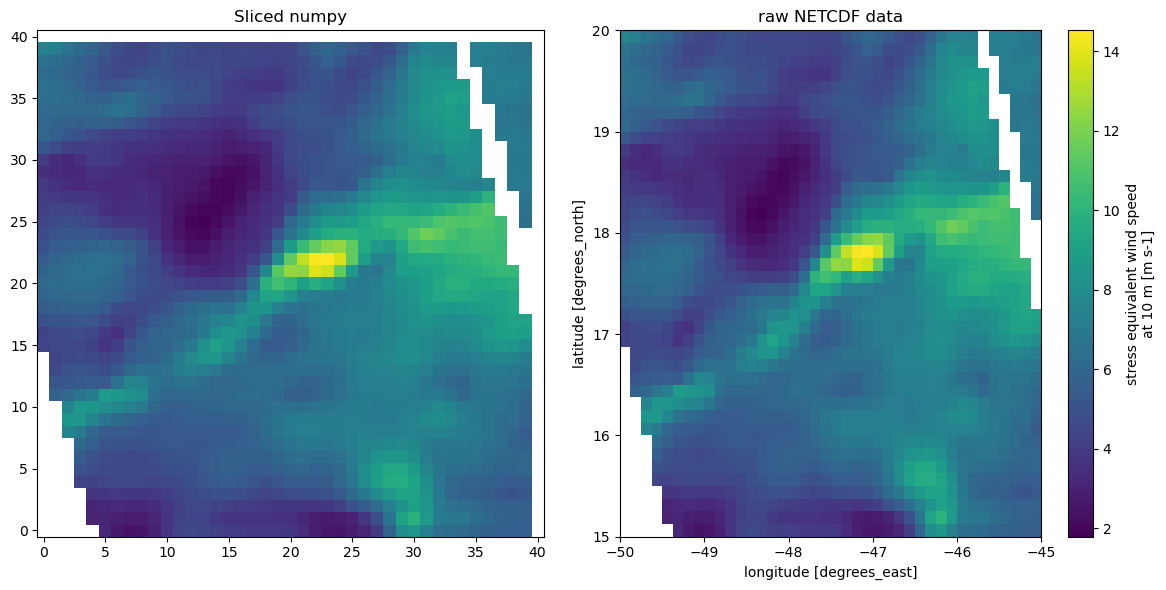

In [14]:
import matplotlib.pyplot as plt

i = 663

# Assuming 'metadata' and 'ds' are defined and contain the required data

latitude_start = metadata.iloc[i]['latitude start']
latitude_end = metadata.iloc[i]['latitude end']
longitude_start = metadata.iloc[i]['longitude start']
longitude_end = metadata.iloc[i]['longitude end']
time = metadata.iloc[i]['time']

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # figsize can be adjusted based on your display needs

# First subplot
ax[0].imshow(spliced_filter_des[i])  # Assuming spliced_filter_des is defined and contains image data
ax[0].invert_yaxis()  # Invert y-axis for the image plot
ax[0].set_title('Sliced numpy')  # Set title for the first subplot

# Second subplot
ds_slice = ds.isel(time=time).wind_speed.sel(latitude=slice(latitude_start, latitude_end), longitude=slice(longitude_start, longitude_end))
ds_slice.plot(ax=ax[1])  # Plotting wind speed data on the second axis
ax[1].set_title('raw NETCDF data')  # Set title for the second subplot

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots


In [12]:
print(np.shape(spliced_filter_des))


(664, 41, 41)
